# Hello NeMo Run Experiments!

This is the second part of our hello world tutorial series for NeMo Run. Please make sure that you have gone through the [first part](hello_world.ipynb) before, since this tutorial builds heavily on the first part.

A key component we have in our NeMo Run is `run.Experiment`. To get an introduction of Experiment, check out its docstring, also posted below:

`run.Experiment` is a context manager to launch and manage multiple runs, all using pure Python. `run.Experiment` provides researchers with a simple and flexible way to create and manage their ML experiments. Building on the core blocks of NeMo Run, the Experiment can be used as an umbrella under which a user can launch different configured functions on multiple remote clusters.

The Experiment context manager takes care of storing the run metadata, launching it on the specified cluster, and syncing the logs and artifacts. Additionally, the Experiment also provides management tools to easily inspect and reproduce past experiments.
Some of the use-cases that it enables are listed below:

1. Check the status and logs of a past experiment
2. Reproduce a past experiment and rerun it
3. Reconstruct a past experiment and relaunch it after some changes
4. Compare different runs of the same experiment.

This API allows users to programmatically define their experiments, all in Python. To get a glance of the flexibility provided, here are some use cases which can be supported by the Experiment in just a few lines of code.

1. Launch a benchmarking run on different GPUs at the same time in parallel
2. Launch a sequential data processing pipeline on a CPU heavy cluster
3. Launch hyperparameter grid search runs on a single cluster in parallel
4. Launch hyperparameter search runs distributed across all available clusters

The docstring also has some code examples, but we will build on `add_object` in the previous tutorial to define a simple experiment and show it's abilities in this tutorial.

Let's get into it.


In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Set up and imports
import nemo_run as run
from simple.add import SomeObject, add_object

### 1. Configuration

First, let's configure the functions we want to run in our experiments. You can configure multiple functions under an experiment. Here, we will configure two functions, which will be partials of `add_object` but with different parameters.

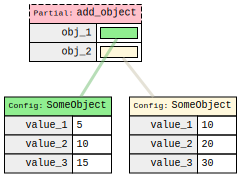

In [2]:
fn_1 = run.Partial(
    add_object,
    obj_1="commonly_used_object",
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
)
fn_1

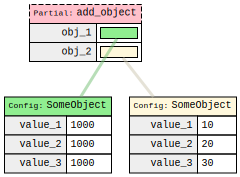

In [3]:
fn_2 = run.Partial(
    add_object,
    # You can also pass in the argument directly instead of as a Config.
    # However, this will run any code inside the `__init__` or `__post_init__` methods of the classes (if its a class).
    obj_1=SomeObject(value_1=1000, value_2=1000, value_3=1000),
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
)

fn_2

# Defining and Running the Experiment

Now, let's say we want to run these two configured functions together and manage them under an experiment. We can do so with just a few lines of code shown below. Try running it: it will launch the two tasks sequentially and wait for them to complete.
Notice that we set `sequential=True`, this is because parallel execution mode is not supported on the local executor as of now. This is intentional as launching parallel processes on your local workstation can quickly eat up your limited resources.
However, our `SlurmExecutor` supports parallel mode, (and is set to `True` by default). This will allow you to run both your configured functions in parallel. An example is shown below:

```python
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)
    exp.add(fn_2, tail_logs=True)
    exp.run()
```

Additionally, you can also launch the functions on separate executors as shown below:

```python
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)

    exp.add(fn_2, executor=your_slurm_executor(), tail_logs=True)
    exp.run()
```

The executor and configured functions are cloned in `exp.add` so you can mutate them as needed. This allows you to overwrite some parameters quickly. See example below:
```python
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)

    fn_1.obj_1.value_1 = 0
    exp.add(fn_1, executor=your_slurm_executor(), tail_logs=True)
    exp.run()
```

>📝 Currently we only support sequential and parallel execution in an experiment. DAG based execution is not yet supported.
>📝 To run the tasks in an experiment in parallel, all executors should support parallel mode as of now. We will relax this restriction soon.

>📝 By default, the experiment metadata is stored in your home folder `~` inside the `.nemo_run` folder. But you can also store it in a separate dir by setting the `NEMORUN_HOME` environment variable.

In [4]:
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)
    exp.add(fn_2, tail_logs=True)
    exp.run()

────────────────────────── Entering Experiment add_object with id: add_object_1721798664 ──────────────────────────

[22:24:24] Launching task simple.add.add_object for experiment add_object                         ]8;id=281076;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=399052;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#553\553]8;;\

Log directory is: /home/hemild/.nemo_run/experiments/add_object/add_object_1721798664/simple.add.add_object
Launched app: local_persistent://nemo_run/simple.add.add_object-crvvbqfn7bzcgd
AppStatus:
    State: RUNNING
    Num Restarts: 0
    Roles: 
    Msg: <NONE>
    Structured Error Msg: <NONE>
    UI URL: file:///home/hemild/.nemo_run/experiments/add_object/add_object_1721798664/simple.add.add_object/nemo_run/simple.add.add_object-crvvbqfn7bzcgd
    


           Launching task simple.add.add_object_1 for experiment add_object                       ]8;id=103800;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=132743;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#553\553]8;;\

Log directory is: /home/hemild/.nemo_run/experiments/add_object/add_object_1721798664/simple.add.add_object_1
Launched app: local_persistent://nemo_run/simple.add.add_object_1-mqf1n5dpq0wggd
AppStatus:
    State: RUNNING
    Num Restarts: 0
    Roles: 
    Msg: <NONE>
    Structured Error Msg: <NONE>
    UI URL: file:///home/hemild/.nemo_run/experiments/add_object/add_object_1721798664/simple.add.add_object_1/nemo_run/simple.add.add_object_1-mqf1n5dpq0wggd
    


───────────────────────────── Waiting for Experiment add_object_1721798664 to finish ──────────────────────────────

Waiting for the app to finish [log=True]...
Waiting for the app to finish [log=True]...


simple.add.add_object/0 result = SomeObject(value_1=15, value_2=30, value_3=45)
simple.add.add_object_1/0 result = SomeObject(value_1=1010, value_2=1020, value_3=1030)


Job finished: SUCCEEDED
AppStatus:
  msg: <NONE>
  num_restarts: 0
  roles: []
  state: SUCCEEDED (4)
  structured_error_msg: <NONE>
  ui_url: file:///home/hemild/.nemo_run/experiments/add_object/add_object_1721798664/simple.add.add_object/nemo_run/simple.add.add_object-crvvbqfn7bzcgd

Job finished: SUCCEEDED
AppStatus:
  msg: <NONE>
  num_restarts: 0
  roles: []
  state: SUCCEEDED (4)
  structured_error_msg: <NONE>
  ui_url: file:///home/hemild/.nemo_run/experiments/add_object/add_object_1721798664/simple.add.add_object_1/nemo_run/simple.add.add_object_1-mqf1n5dpq0wggd



[22:24:26]                        Experiment Status: add_object_1721798664                        ]8;id=234801;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=233216;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#639\639]8;;\
           ┏━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓                  
           ┃ task   ┃ handle         ┃ directory              ┃ status ┃ executor               ┃                  
           ┡━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect    │ _object-crvvbq │ t/add_object_172179866 │        │                        │                  
           │        │ fn7bzcgd       │ 4/simple.add.add_objec │        │                        │                  
           │        │                │ t                      │        │                        │                  
           │        │                │                        │        │                        │                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect_1  │ _object_1-mqf1 │ t/add_object_172179866 │        │                        │                  
           │        │ n5dpq0wggd     │ 4/simple.add.add_objec │        │                        │                  
           │        │                │ t_1                    │        │                        │                  
           │        │                │                        │        │                        │                  
           └────────┴────────────────┴────────────────────────┴────────┴────────────────────────┘                  

                                                                                                                   
# The experiment was run with the following tasks: ['simple.add.add_object', 'simple.add.add_object_1']            
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("add_object_1721798664")                                                       
experiment.status() # Gets the overall status                                                                      
experiment.logs("simple.add.add_object") # Gets the log for the provided task                                      
experiment.cancel("simple.add.add_object") # Cancels the provided task if still running                            
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemorun experiment status add_object_1721798664                                                                    
nemorun experiment logs add_object_1721798664 0                                                                    
nemorun experiment cancel add_object_1721798664 0                                                                  
                                                                                                                   

# Inspecting an experiment

Additionally, you can also reconstruct and inspect an old experiment. There are a few utilities which allow you to list and inspect an experiment run. 
Run the cells below to see the current management capabilities.

In [5]:
# List all runs of an experiment
# The last suffix is the timestamp and results are sorted in ascending order of timestamps
run.Experiment.catalog("add_object")

['add_object_1721798664']

In [6]:
# Reconstruct an experiment and inspect its status, logs, etc
# if id is None, it will take the latest run.
# if id is provided, it will use that particular run.
# status and logs can be used outisde the context manager too
with run.Experiment.from_title("add_object") as exp:
    exp.status()
    exp.logs(task_id="simple.add.add_object")

────────────────────────── Entering Experiment add_object with id: add_object_1721798664 ──────────────────────────

[22:24:33]                        Experiment Status: add_object_1721798664                        ]8;id=311751;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=214166;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#639\639]8;;\
           ┏━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓                  
           ┃ task   ┃ handle         ┃ directory              ┃ status ┃ executor               ┃                  
           ┡━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect    │ _object-crvvbq │ t/add_object_172179866 │        │                        │                  
           │        │ fn7bzcgd       │ 4/simple.add.add_objec │        │                        │                  
           │        │                │ t                      │        │                        │                  
           │        │                │                        │        │                        │                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect_1  │ _object_1-mqf1 │ t/add_object_172179866 │        │                        │                  
           │        │ n5dpq0wggd     │ 4/simple.add.add_objec │        │                        │                  
           │        │                │ t_1                    │        │                        │                  
           │        │                │                        │        │                        │                  
           └────────┴────────────────┴────────────────────────┴────────┴────────────────────────┘                  

           Fetching logs for simple.add.add_object                                                ]8;id=218750;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=338370;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#674\674]8;;\

simple.add.add_object/0 result = SomeObject(value_1=15, value_2=30, value_3=45)


In [7]:
# Create a new run of an old experiment
exp = run.Experiment.from_title("add_object")
exp.status()
exp.reset()

with exp:
    exp.run(sequential=True)


[22:24:36]                        Experiment Status: add_object_1721798664                        ]8;id=888341;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=83467;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#639\639]8;;\
           ┏━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓                  
           ┃ task   ┃ handle         ┃ directory              ┃ status ┃ executor               ┃                  
           ┡━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect    │ _object-crvvbq │ t/add_object_172179866 │        │                        │                  
           │        │ fn7bzcgd       │ 4/simple.add.add_objec │        │                        │                  
           │        │                │ t                      │        │                        │                  
           │        │                │                        │        │                        │                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect_1  │ _object_1-mqf1 │ t/add_object_172179866 │        │                        │                  
           │        │ n5dpq0wggd     │ 4/simple.add.add_objec │        │                        │                  
           │        │                │ t_1                    │        │                        │                  
           │        │                │                        │        │                        │                  
           └────────┴────────────────┴────────────────────────┴────────┴────────────────────────┘                  

────────────────────────── Entering Experiment add_object with id: add_object_1721798676 ──────────────────────────

           Dependencies not supported for atleast one of {<class                                  ]8;id=267853;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=981179;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#537\537]8;;\
           'nemo_run.core.execution.local.LocalExecutor'>}.Tasks will be run one after the other,                  
           please keep the process alive.                                                                          

           Launching task simple.add.add_object for experiment add_object                         ]8;id=846051;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=966263;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#553\553]8;;\

simple.add.add_object/0 result = SomeObject(value_1=15, value_2=30, value_3=45)


[22:24:38] Launching task simple.add.add_object_1 for experiment add_object                       ]8;id=96219;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=39423;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#553\553]8;;\

simple.add.add_object_1/0 result = SomeObject(value_1=1010, value_2=1020, value_3=1030)


───────────────────────────── Waiting for Experiment add_object_1721798676 to finish ──────────────────────────────

[22:24:40]                        Experiment Status: add_object_1721798676                        ]8;id=904089;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=867625;file:///home/hemild/dev/nemo-sdk/src/nemo_run/run/experiment.py#639\639]8;;\
           ┏━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓                  
           ┃ task   ┃ handle         ┃ directory              ┃ status ┃ executor               ┃                  
           ┡━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect    │ _object-lm5j0x │ t/add_object_172179867 │        │                        │                  
           │        │ 639bgcsd       │ 6/simple.add.add_objec │        │                        │                  
           │        │                │ t                      │        │                        │                  
           │        │                │                        │        │                        │                  
           │ simple │ local_persiste │ Local:                 │ SUCCE… │ LocalExecutor          │                  
           │ .add.a │ nt://nemo_run/ │ /home/hemild/.nemo_run │        │                        │                  
           │ dd_obj │ simple.add.add │ /experiments/add_objec │        │                        │                  
           │ ect_1  │ _object_1-gwhs │ t/add_object_172179867 │        │                        │                  
           │        │ 5dj7s5b47c     │ 6/simple.add.add_objec │        │                        │                  
           │        │                │ t_1                    │        │                        │                  
           │        │                │                        │        │                        │                  
           └────────┴────────────────┴────────────────────────┴────────┴────────────────────────┘                  

                                                                                                                   
# The experiment was run with the following tasks: ['simple.add.add_object', 'simple.add.add_object_1']            
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("add_object_1721798676")                                                       
experiment.status() # Gets the overall status                                                                      
experiment.logs("simple.add.add_object") # Gets the log for the provided task                                      
experiment.cancel("simple.add.add_object") # Cancels the provided task if still running                            
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemorun experiment status add_object_1721798676                                                                    
nemorun experiment logs add_object_1721798676 0                                                                    
nemorun experiment cancel add_object_1721798676 0                                                                  
                                                                                                                   